In [43]:
#Import the libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean 
import matplotlib.pyplot as plt
import numpy as np
import pdb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [44]:
#Read the dataset
dataset = datasets.ImageFolder('ck/data/',transform=transforms.Compose([transforms.ToTensor()]))

In [45]:
#Split the data into train and test
def train_val_test_dataset(dataset, targets, test_split=0.2):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split, stratify=targets)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, test_idx)
    return datasets

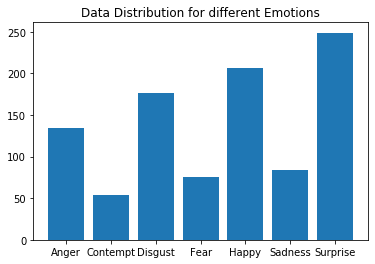

In [46]:
#Label Distribution
labels = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']
freq = Counter(dataset.targets).values()
fig = plt.figure()
plt.bar(labels,freq)
plt.title('Data Distribution for different Emotions')
plt.show()

In [47]:
#Get train and test loaders
dataset = train_val_test_dataset(dataset, dataset.targets)
trainloader = torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset['test'], batch_size=64)

In [48]:
def train_softmax(model, criterion, optimizer, trainloader, num_classes=7):
    model.train()
    train_loss = [];
    train_acc = [];
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.cuda(), labels.cuda()
        features, outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print(f"Batch {batch_idx+1}.." f"Loss: {loss.item()}")
        
    acc, err = test_softmax(model, trainloader)
    print(f"Train Accuracy {acc}.. "
          f"Train Error {err}.. ")
    print("**********************Epoch END******************")

    return mean(train_loss), acc

In [49]:
def test_softmax(model, testloader, num_classes=7):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.cuda(), labels.cuda()
            features, outputs = model(data)
            predictions = outputs.data.max(1)[1]
            total += labels.size(0)
            correct += (predictions == labels.data).sum()
        
    acc = correct * 100. / total
    err = 100. - acc
    return acc, err

In [50]:
class ConvNet(nn.Module):    
    """LeNet++ as described in the Center Loss paper."""
    def __init__(self, num_classes=7):      
        super(ConvNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=2)
        self.prelu1_2 = nn.PReLU()
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=2)
        self.prelu2_2 = nn.PReLU()
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=2)
        self.prelu3_2 = nn.PReLU()
        
        self.fc1 = nn.Linear(128*9*9, 256)
        self.prelu_fc1 = nn.PReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 128*9*9)
        x = self.prelu_fc1(self.fc1(x))
        y = self.fc2(x)

        return x, y

In [51]:
def Get_Preds(model, dataloader):
    model.eval()
    ypred = []
    ytrue = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda()
            features, outputs = model(data)
            predictions = outputs.data.max(1)[1]
            ypred.append(predictions.cpu().numpy())
            ytrue.append(labels.cpu().numpy())
        
    return ypred, ytrue

In [52]:
model = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tot_loss = []
train_acc = []
test_acc = []

for epoch in range(40):
    print("==> Epoch {}/{}".format(epoch+1, 40))
    temp1, temp2 = train_softmax(model, criterion, optimizer,trainloader)
    tot_loss.append(temp1)
    train_acc.append(temp2)

    print("==> Test")
    acc, err = test_softmax(model, testloader)
    print("Accuracy (%): {}\t Error rate (%): {}".format(acc, err))
    test_acc.append(acc)

==> Epoch 1/50
Batch 1..Loss: 1.931863784790039
Batch 2..Loss: 1.8659409284591675
Batch 3..Loss: 2.0524446964263916
Batch 4..Loss: 1.8085579872131348
Batch 5..Loss: 1.8636131286621094
Batch 6..Loss: 1.8297810554504395
Batch 7..Loss: 1.861181378364563
Batch 8..Loss: 1.892593264579773
Batch 9..Loss: 1.8466806411743164
Batch 10..Loss: 1.844346284866333
Batch 11..Loss: 1.861161231994629
Batch 12..Loss: 1.8238905668258667
Batch 13..Loss: 1.8333308696746826
Train Accuracy 25.382652282714844.. Train Error 74.61734771728516.. 
**********************Epoch END******************
==> Test
Accuracy (%): 25.38071060180664	 Error rate (%): 74.61929321289062
==> Epoch 2/50
Batch 1..Loss: 1.870463490486145
Batch 2..Loss: 1.8211599588394165
Batch 3..Loss: 1.8191126585006714
Batch 4..Loss: 1.8457822799682617
Batch 5..Loss: 1.9055215120315552
Batch 6..Loss: 1.8511942625045776
Batch 7..Loss: 1.881792426109314
Batch 8..Loss: 1.8003416061401367
Batch 9..Loss: 1.8133530616760254
Batch 10..Loss: 1.703736424446

Batch 10..Loss: 0.037735022604465485
Batch 11..Loss: 0.03147904574871063
Batch 12..Loss: 0.11039507389068604
Batch 13..Loss: 0.2531975507736206
Train Accuracy 98.59693908691406.. Train Error 1.4030609130859375.. 
**********************Epoch END******************
==> Test
Accuracy (%): 93.90863037109375	 Error rate (%): 6.09136962890625
==> Epoch 14/50
Batch 1..Loss: 0.05338702350854874
Batch 2..Loss: 0.07062140852212906
Batch 3..Loss: 0.15333500504493713
Batch 4..Loss: 0.3186264932155609
Batch 5..Loss: 0.22537915408611298
Batch 6..Loss: 0.16381362080574036
Batch 7..Loss: 0.21394291520118713
Batch 8..Loss: 0.16584512591362
Batch 9..Loss: 0.15619248151779175
Batch 10..Loss: 0.3512326180934906
Batch 11..Loss: 0.018590882420539856
Batch 12..Loss: 0.06936493515968323
Batch 13..Loss: 0.5606027245521545
Train Accuracy 89.28571319580078.. Train Error 10.714286804199219.. 
**********************Epoch END******************
==> Test
Accuracy (%): 89.34010314941406	 Error rate (%): 10.659896850585

Batch 13..Loss: 0.0014720559120178223
Train Accuracy 100.0.. Train Error 0.0.. 
**********************Epoch END******************
==> Test
Accuracy (%): 98.47715759277344	 Error rate (%): 1.5228424072265625
==> Epoch 26/50
Batch 1..Loss: 0.003195345401763916
Batch 2..Loss: 0.0001582503318786621
Batch 3..Loss: 0.0006118863821029663
Batch 4..Loss: 0.0004982054233551025
Batch 5..Loss: 0.0010640472173690796
Batch 6..Loss: 0.0021046996116638184
Batch 7..Loss: 0.0018786191940307617
Batch 8..Loss: 0.0002653151750564575
Batch 9..Loss: 0.0014694035053253174
Batch 10..Loss: 0.002121180295944214
Batch 11..Loss: 0.005029961466789246
Batch 12..Loss: 0.004753097891807556
Batch 13..Loss: 0.00024688243865966797
Train Accuracy 100.0.. Train Error 0.0.. 
**********************Epoch END******************
==> Test
Accuracy (%): 98.47715759277344	 Error rate (%): 1.5228424072265625
==> Epoch 27/50
Batch 1..Loss: 0.0016251951456069946
Batch 2..Loss: 0.0009980052709579468
Batch 3..Loss: 0.0004627257585525512

**********************Epoch END******************
==> Test
Accuracy (%): 98.47715759277344	 Error rate (%): 1.5228424072265625
==> Epoch 38/50
Batch 1..Loss: 8.67992639541626e-05
Batch 2..Loss: 0.0001175999641418457
Batch 3..Loss: 0.00028526782989501953
Batch 4..Loss: 0.00021466612815856934
Batch 5..Loss: 0.00027517974376678467
Batch 6..Loss: 4.245340824127197e-05
Batch 7..Loss: 8.109211921691895e-05
Batch 8..Loss: 7.809698581695557e-05
Batch 9..Loss: 0.00014188885688781738
Batch 10..Loss: 0.00010402500629425049
Batch 11..Loss: 8.256733417510986e-05
Batch 12..Loss: 0.00013214349746704102
Batch 13..Loss: 2.6345252990722656e-05
Train Accuracy 100.0.. Train Error 0.0.. 
**********************Epoch END******************
==> Test
Accuracy (%): 98.47715759277344	 Error rate (%): 1.5228424072265625
==> Epoch 39/50
Batch 1..Loss: 0.00010602176189422607
Batch 2..Loss: 0.00010278820991516113
Batch 3..Loss: 0.00013093650341033936
Batch 4..Loss: 0.00017157196998596191
Batch 5..Loss: 0.000153675675

Text(0, 0.5, 'Loss')

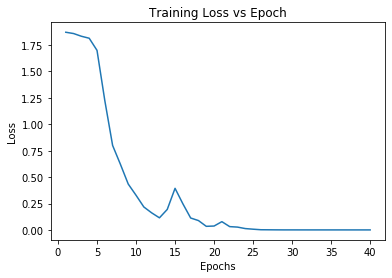

In [53]:
plt.figure()
plt.plot(np.arange(1,41), tot_loss)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

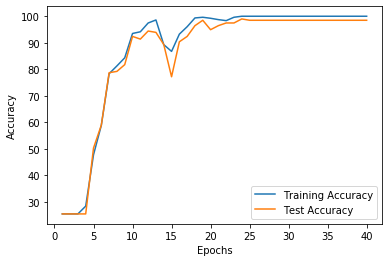

In [55]:
plt.figure()
plt.plot(np.arange(1,41), train_acc)
plt.plot(np.arange(1,41), test_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Test Accuracy'])

In [56]:
ypred_train, ytrue_train = Get_Preds(model, trainloader)
ypred_test, ytrue_test = Get_Preds(model, testloader)
ypred_test = np.concatenate(ypred_test)
ytrue_test = np.concatenate(ytrue_test)

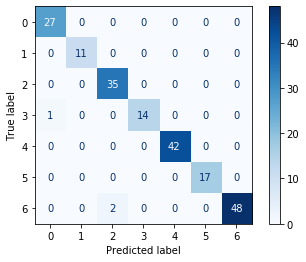

In [57]:
cm = confusion_matrix(ytrue_test, ypred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2','3','4','5','6'])
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [58]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=7, feat_dim=2):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [67]:
def train(model, criterion_xent, criterion_cent, optimizer_model, optimizer_centloss,trainloader, num_classes=7):
    
    model.train()
    xent_losses = []
    cent_losses = []
    losses = []
    weight_cent = 0.5
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.cuda(), labels.cuda()
        features, outputs = model(data)
        loss_xent = criterion_xent(outputs, labels)
        loss_cent = criterion_cent(features, labels)
        loss_cent *= weight_cent
        loss = loss_xent + loss_cent
        optimizer_model.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        optimizer_model.step()
        # by doing so, weight_cent would not impact on the learning of centers
        for param in criterion_cent.parameters():
            param.grad.data *= (1. / weight_cent)
        optimizer_centloss.step()

        losses.append(loss.item())
        xent_losses.append(loss_xent.item())
        cent_losses.append(loss_cent.item())
        print("Batch {}/{}\t Loss {:.6f} ({:.6f}) XentLoss {:.6f} ({:.6f}) CenterLoss {:.6f} ({:.6f})" \
              .format(batch_idx+1, len(trainloader), loss.item(), mean(losses), loss_xent.item(), mean(xent_losses), loss_cent.item(), mean(cent_losses)))
    acc, err = test(model, trainloader)
    return mean(losses), mean(xent_losses), mean(cent_losses), acc

In [68]:
def test(model, testloader, num_classes=7):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.cuda(), labels.cuda()
            features, outputs = model(data)
            predictions = outputs.data.max(1)[1]
            total += labels.size(0)
            correct += (predictions == labels.data).sum()
        
    acc = correct * 100. / total
    err = 100. - acc
    return acc, err

In [74]:
model = ConvNet().cuda()
criterion_xent = nn.CrossEntropyLoss()
criterion_cent = CenterLoss(num_classes=7, feat_dim=256)
optimizer_model = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_centloss = torch.optim.SGD(criterion_cent.parameters(), lr=0.5)

In [75]:
tot_loss = []
loss_cent = []
loss_ce = []
train_acc = []
test_acc = []

for epoch in range(40):
    print("==> Epoch {}/{}".format(epoch+1, 40))
    temp1, temp2, temp3, temp4 = train(model, criterion_xent, criterion_cent,
          optimizer_model, optimizer_centloss,
          trainloader)
    tot_loss.append(temp1)
    loss_ce.append(temp2)
    loss_cent.append(temp3)
    train_acc.append(temp4)
    
    print("==> Test")
    acc, err = test(model, testloader)
    test_acc.append(acc)
    print("Accuracy (%): {}\t Error rate (%): {}".format(acc, err))

==> Epoch 1/40
Batch 1/13	 Loss 132.251373 (132.251373) XentLoss 1.941165 (1.941165) CenterLoss 130.310211 (130.310211)
Batch 2/13	 Loss 86.900757 (109.576065) XentLoss 1.938553 (1.939859) CenterLoss 84.962204 (107.636208)
Batch 3/13	 Loss 59.305187 (92.819106) XentLoss 1.946941 (1.942219) CenterLoss 57.358246 (90.876887)
Batch 4/13	 Loss 36.131123 (78.647110) XentLoss 1.924202 (1.937715) CenterLoss 34.206921 (76.709395)
Batch 5/13	 Loss 27.731936 (68.464075) XentLoss 1.922307 (1.934634) CenterLoss 25.809628 (66.529442)
Batch 6/13	 Loss 32.008980 (62.388226) XentLoss 1.944864 (1.936339) CenterLoss 30.064117 (60.451888)
Batch 7/13	 Loss 18.401527 (56.104412) XentLoss 1.873180 (1.927316) CenterLoss 16.528347 (54.177096)
Batch 8/13	 Loss 13.398463 (50.766168) XentLoss 1.870372 (1.920198) CenterLoss 11.528091 (48.845971)
Batch 9/13	 Loss 12.552175 (46.520169) XentLoss 1.853333 (1.912769) CenterLoss 10.698841 (44.607401)
Batch 10/13	 Loss 13.276040 (43.195756) XentLoss 1.902022 (1.911694) C

==> Epoch 7/40
Batch 1/13	 Loss 1.835482 (1.835482) XentLoss 1.828697 (1.828697) CenterLoss 0.006785 (0.006785)
Batch 2/13	 Loss 1.827057 (1.831269) XentLoss 1.822385 (1.825541) CenterLoss 0.004672 (0.005728)
Batch 3/13	 Loss 1.829172 (1.830570) XentLoss 1.822502 (1.824528) CenterLoss 0.006670 (0.006042)
Batch 4/13	 Loss 1.890073 (1.845446) XentLoss 1.884931 (1.839629) CenterLoss 0.005143 (0.005817)
Batch 5/13	 Loss 1.775925 (1.831542) XentLoss 1.766039 (1.824911) CenterLoss 0.009886 (0.006631)
Batch 6/13	 Loss 1.779908 (1.822936) XentLoss 1.769519 (1.815679) CenterLoss 0.010390 (0.007258)
Batch 7/13	 Loss 1.885916 (1.831933) XentLoss 1.880689 (1.824966) CenterLoss 0.005226 (0.006967)
Batch 8/13	 Loss 1.776366 (1.824987) XentLoss 1.765824 (1.817573) CenterLoss 0.010543 (0.007414)
Batch 9/13	 Loss 1.920290 (1.835577) XentLoss 1.915787 (1.828486) CenterLoss 0.004503 (0.007091)
Batch 10/13	 Loss 1.766937 (1.828713) XentLoss 1.762950 (1.821932) CenterLoss 0.003987 (0.006780)
Batch 11/13	 L

Batch 1/13	 Loss 1.373971 (1.373971) XentLoss 1.278276 (1.278276) CenterLoss 0.095695 (0.095695)
Batch 2/13	 Loss 1.510809 (1.442390) XentLoss 1.358900 (1.318588) CenterLoss 0.151909 (0.123802)
Batch 3/13	 Loss 1.363093 (1.415957) XentLoss 1.266771 (1.301316) CenterLoss 0.096322 (0.114642)
Batch 4/13	 Loss 1.515210 (1.440771) XentLoss 1.423936 (1.331971) CenterLoss 0.091274 (0.108800)
Batch 5/13	 Loss 1.460413 (1.444699) XentLoss 1.363950 (1.338367) CenterLoss 0.096462 (0.106332)
Batch 6/13	 Loss 1.585883 (1.468230) XentLoss 1.409402 (1.350206) CenterLoss 0.176482 (0.118024)
Batch 7/13	 Loss 1.440389 (1.464252) XentLoss 1.312959 (1.344885) CenterLoss 0.127430 (0.119368)
Batch 8/13	 Loss 1.510843 (1.470076) XentLoss 1.393844 (1.351005) CenterLoss 0.116998 (0.119071)
Batch 9/13	 Loss 1.372891 (1.459278) XentLoss 1.246327 (1.339374) CenterLoss 0.126564 (0.119904)
Batch 10/13	 Loss 1.516503 (1.465000) XentLoss 1.389724 (1.344409) CenterLoss 0.126779 (0.120592)
Batch 11/13	 Loss 1.321360 (1

Batch 1/13	 Loss 0.695561 (0.695561) XentLoss 0.559717 (0.559717) CenterLoss 0.135844 (0.135844)
Batch 2/13	 Loss 0.900161 (0.797861) XentLoss 0.713398 (0.636557) CenterLoss 0.186763 (0.161304)
Batch 3/13	 Loss 0.741486 (0.779070) XentLoss 0.586116 (0.619744) CenterLoss 0.155370 (0.159326)
Batch 4/13	 Loss 0.790143 (0.781838) XentLoss 0.603463 (0.615673) CenterLoss 0.186680 (0.166164)
Batch 5/13	 Loss 0.867218 (0.798914) XentLoss 0.707060 (0.633951) CenterLoss 0.160158 (0.164963)
Batch 6/13	 Loss 0.760268 (0.792473) XentLoss 0.609021 (0.629796) CenterLoss 0.151247 (0.162677)
Batch 7/13	 Loss 0.880211 (0.805007) XentLoss 0.714072 (0.641835) CenterLoss 0.166139 (0.163172)
Batch 8/13	 Loss 0.734406 (0.796182) XentLoss 0.569270 (0.632764) CenterLoss 0.165137 (0.163417)
Batch 9/13	 Loss 0.786071 (0.795058) XentLoss 0.627854 (0.632219) CenterLoss 0.158217 (0.162840)
Batch 10/13	 Loss 0.626152 (0.778168) XentLoss 0.491552 (0.618152) CenterLoss 0.134600 (0.160016)
Batch 11/13	 Loss 0.705345 (0

Batch 1/13	 Loss 0.375792 (0.375792) XentLoss 0.240259 (0.240259) CenterLoss 0.135533 (0.135533)
Batch 2/13	 Loss 0.290043 (0.332917) XentLoss 0.174559 (0.207409) CenterLoss 0.115484 (0.125508)
Batch 3/13	 Loss 0.349027 (0.338287) XentLoss 0.208739 (0.207852) CenterLoss 0.140288 (0.130435)
Batch 4/13	 Loss 0.290636 (0.326374) XentLoss 0.192001 (0.203889) CenterLoss 0.098635 (0.122485)
Batch 5/13	 Loss 0.418733 (0.344846) XentLoss 0.281441 (0.219400) CenterLoss 0.137291 (0.125446)
Batch 6/13	 Loss 0.389948 (0.352363) XentLoss 0.251478 (0.224746) CenterLoss 0.138471 (0.127617)
Batch 7/13	 Loss 0.263838 (0.339717) XentLoss 0.164907 (0.216198) CenterLoss 0.098931 (0.123519)
Batch 8/13	 Loss 0.271345 (0.331170) XentLoss 0.176767 (0.211269) CenterLoss 0.094578 (0.119901)
Batch 9/13	 Loss 0.326706 (0.330674) XentLoss 0.219764 (0.212213) CenterLoss 0.106941 (0.118461)
Batch 10/13	 Loss 0.306013 (0.328208) XentLoss 0.184476 (0.209439) CenterLoss 0.121537 (0.118769)
Batch 11/13	 Loss 0.242859 (0

Batch 1/13	 Loss 0.126617 (0.126617) XentLoss 0.064199 (0.064199) CenterLoss 0.062417 (0.062417)
Batch 2/13	 Loss 0.122767 (0.124692) XentLoss 0.051342 (0.057770) CenterLoss 0.071426 (0.066921)
Batch 3/13	 Loss 0.123797 (0.124394) XentLoss 0.062826 (0.059456) CenterLoss 0.060971 (0.064938)
Batch 4/13	 Loss 0.119962 (0.123286) XentLoss 0.052155 (0.057631) CenterLoss 0.067806 (0.065655)
Batch 5/13	 Loss 0.120657 (0.122760) XentLoss 0.071864 (0.060477) CenterLoss 0.048792 (0.062283)
Batch 6/13	 Loss 0.130373 (0.124029) XentLoss 0.072232 (0.062437) CenterLoss 0.058140 (0.061592)
Batch 7/13	 Loss 0.129084 (0.124751) XentLoss 0.064109 (0.062676) CenterLoss 0.064975 (0.062075)
Batch 8/13	 Loss 0.118912 (0.124021) XentLoss 0.070345 (0.063634) CenterLoss 0.048567 (0.060387)
Batch 9/13	 Loss 0.109513 (0.122409) XentLoss 0.049512 (0.062065) CenterLoss 0.060001 (0.060344)
Batch 10/13	 Loss 0.109109 (0.121079) XentLoss 0.061361 (0.061995) CenterLoss 0.047749 (0.059084)
Batch 11/13	 Loss 0.134796 (0

Batch 1/13	 Loss 0.063879 (0.063879) XentLoss 0.022947 (0.022947) CenterLoss 0.040933 (0.040933)
Batch 2/13	 Loss 0.054492 (0.059186) XentLoss 0.027289 (0.025118) CenterLoss 0.027203 (0.034068)
Batch 3/13	 Loss 0.060078 (0.059483) XentLoss 0.026524 (0.025587) CenterLoss 0.033554 (0.033897)
Batch 4/13	 Loss 0.056770 (0.058805) XentLoss 0.030138 (0.026725) CenterLoss 0.026631 (0.032080)
Batch 5/13	 Loss 0.063706 (0.059785) XentLoss 0.030112 (0.027402) CenterLoss 0.033594 (0.032383)
Batch 6/13	 Loss 0.046389 (0.057552) XentLoss 0.024905 (0.026986) CenterLoss 0.021483 (0.030566)
Batch 7/13	 Loss 0.056152 (0.057352) XentLoss 0.028444 (0.027194) CenterLoss 0.027708 (0.030158)
Batch 8/13	 Loss 0.054165 (0.056954) XentLoss 0.028927 (0.027411) CenterLoss 0.025238 (0.029543)
Batch 9/13	 Loss 0.049501 (0.056126) XentLoss 0.024000 (0.027032) CenterLoss 0.025501 (0.029094)
Batch 10/13	 Loss 0.054151 (0.055928) XentLoss 0.028159 (0.027145) CenterLoss 0.025992 (0.028784)
Batch 11/13	 Loss 0.061138 (0

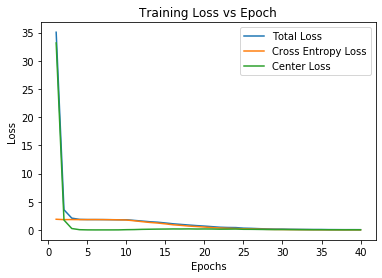

In [76]:
plt.figure()
plt.plot(np.arange(1,41), tot_loss)
plt.plot(np.arange(1,41), loss_ce)
plt.plot(np.arange(1,41), loss_cent)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Total Loss','Cross Entropy Loss','Center Loss'])

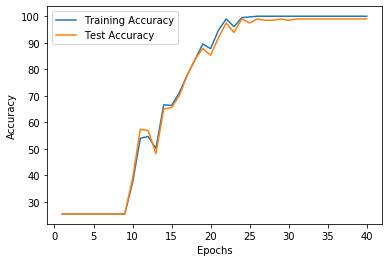

In [77]:
plt.figure()
plt.plot(np.arange(1,41), train_acc)
plt.plot(np.arange(1,41), test_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Test Accuracy'])

In [78]:
ypred_train, ytrue_train = Get_Preds(model, trainloader)
ypred_test, ytrue_test = Get_Preds(model, testloader)
ypred_test = np.concatenate(ypred_test)
ytrue_test = np.concatenate(ytrue_test)

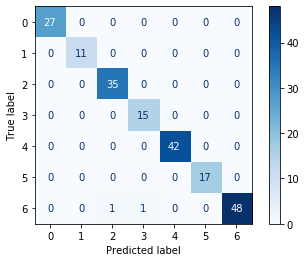

In [79]:
cm = confusion_matrix(ytrue_test, ypred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2','3','4','5','6'])
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [80]:
class ConvNet_feature2d(nn.Module):    
    """LeNet++ as described in the Center Loss paper."""
    def __init__(self, num_classes=7):      
        super(ConvNet_feature2d, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=2)
        self.prelu1_2 = nn.PReLU()
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=2)
        self.prelu2_2 = nn.PReLU()
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=2)
        self.prelu3_2 = nn.PReLU()
        
        self.fc1 = nn.Linear(128*9*9, 2)
        self.prelu_fc1 = nn.PReLU()
        self.fc2 = nn.Linear(2, num_classes)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 128*9*9)
        x = self.prelu_fc1(self.fc1(x))
        y = self.fc2(x)

        return x, y

In [ ]:
def Get_Features(model, dataloader):
    model.eval()
    ypred = []
    ytrue = []
    feat = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda()
            features, outputs = model(data)
            predictions = outputs.data.max(1)[1]
            ypred.append(predictions.cpu().numpy())
            ytrue.append(labels.cpu().numpy())
            feat.append(features.cpu().numpy())
        
    return ypred, ytrue, feat

In [81]:
model = ConvNet_feature2d().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(40):
    print("==> Epoch {}/{}".format(epoch+1, 40))
    train_softmax(model, criterion, optimizer,trainloader)

    print("==> Test")
    acc, err = test_softmax(model, testloader)
    print("Accuracy (%): {}\t Error rate (%): {}".format(acc, err))

==> Epoch 1/40
Batch 1..Loss: 2.1393940448760986
Batch 2..Loss: 2.014726400375366
Batch 3..Loss: 2.0241477489471436
Batch 4..Loss: 1.9830808639526367
Batch 5..Loss: 1.9209215641021729
Batch 6..Loss: 2.092787981033325
Batch 7..Loss: 2.0132415294647217
Batch 8..Loss: 1.9978286027908325
Batch 9..Loss: 2.0282957553863525
Batch 10..Loss: 1.9854681491851807
Batch 11..Loss: 1.9597285985946655
Batch 12..Loss: 1.9209052324295044
Batch 13..Loss: 2.010744571685791
Train Accuracy 21.045917510986328.. Train Error 78.95408630371094.. 
**********************Epoch END******************
==> Test
Accuracy (%): 21.319795608520508	 Error rate (%): 78.68020629882812
==> Epoch 2/40
Batch 1..Loss: 1.9348666667938232
Batch 2..Loss: 1.931776762008667
Batch 3..Loss: 2.0556793212890625
Batch 4..Loss: 1.9165458679199219
Batch 5..Loss: 1.9941024780273438
Batch 6..Loss: 1.9919582605361938
Batch 7..Loss: 1.910498857498169
Batch 8..Loss: 1.939014196395874
Batch 9..Loss: 2.0063631534576416
Batch 10..Loss: 1.9760864973

Batch 10..Loss: 0.746444821357727
Batch 11..Loss: 0.6230366826057434
Batch 12..Loss: 0.713589608669281
Batch 13..Loss: 0.59535151720047
Train Accuracy 68.62244415283203.. Train Error 31.37755584716797.. 
**********************Epoch END******************
==> Test
Accuracy (%): 66.4974594116211	 Error rate (%): 33.502540588378906
==> Epoch 14/40
Batch 1..Loss: 0.8872939348220825
Batch 2..Loss: 0.9676471948623657
Batch 3..Loss: 0.6518845558166504
Batch 4..Loss: 1.2267144918441772
Batch 5..Loss: 0.9865158796310425
Batch 6..Loss: 0.5930255055427551
Batch 7..Loss: 0.9557766914367676
Batch 8..Loss: 0.9539071321487427
Batch 9..Loss: 0.6113038659095764
Batch 10..Loss: 0.6656086444854736
Batch 11..Loss: 0.829670786857605
Batch 12..Loss: 0.7630272507667542
Batch 13..Loss: 0.7031264305114746
Train Accuracy 76.91326141357422.. Train Error 23.08673858642578.. 
**********************Epoch END******************
==> Test
Accuracy (%): 73.60405731201172	 Error rate (%): 26.39594268798828
==> Epoch 15/40

Accuracy (%): 80.20304107666016	 Error rate (%): 19.796958923339844
==> Epoch 26/40
Batch 1..Loss: 0.42361611127853394
Batch 2..Loss: 0.4982532560825348
Batch 3..Loss: 0.5912020802497864
Batch 4..Loss: 0.45560550689697266
Batch 5..Loss: 0.22389422357082367
Batch 6..Loss: 0.4227232336997986
Batch 7..Loss: 0.3215991258621216
Batch 8..Loss: 0.2874544560909271
Batch 9..Loss: 0.36731386184692383
Batch 10..Loss: 0.30194729566574097
Batch 11..Loss: 0.22788271307945251
Batch 12..Loss: 0.3200046420097351
Batch 13..Loss: 0.6305806636810303
Train Accuracy 88.5204086303711.. Train Error 11.479591369628906.. 
**********************Epoch END******************
==> Test
Accuracy (%): 85.78679656982422	 Error rate (%): 14.213203430175781
==> Epoch 27/40
Batch 1..Loss: 0.25378674268722534
Batch 2..Loss: 0.3832629323005676
Batch 3..Loss: 0.3787277340888977
Batch 4..Loss: 0.3438247740268707
Batch 5..Loss: 0.2913029193878174
Batch 6..Loss: 0.2793946862220764
Batch 7..Loss: 0.2569407522678375
Batch 8..Loss:

Batch 4..Loss: 0.09564919769763947
Batch 5..Loss: 0.0949740782380104
Batch 6..Loss: 0.10248943418264389
Batch 7..Loss: 0.10926462709903717
Batch 8..Loss: 0.09907098859548569
Batch 9..Loss: 0.1556117832660675
Batch 10..Loss: 0.15567761659622192
Batch 11..Loss: 0.03741507977247238
Batch 12..Loss: 0.04500821977853775
Batch 13..Loss: 0.03588095307350159
Train Accuracy 96.93877410888672.. Train Error 3.0612258911132812.. 
**********************Epoch END******************
==> Test
Accuracy (%): 93.40101623535156	 Error rate (%): 6.5989837646484375
==> Epoch 39/40
Batch 1..Loss: 0.14763402938842773
Batch 2..Loss: 0.1090940609574318
Batch 3..Loss: 0.06350823491811752
Batch 4..Loss: 0.07989770919084549
Batch 5..Loss: 0.032335538417100906
Batch 6..Loss: 0.08800039440393448
Batch 7..Loss: 0.04052691534161568
Batch 8..Loss: 0.04866298288106918
Batch 9..Loss: 0.02448483556509018
Batch 10..Loss: 0.02883046306669712
Batch 11..Loss: 0.0782051756978035
Batch 12..Loss: 0.01798880100250244
Batch 13..Loss

In [83]:
ypred_train, ytrue_train, feat_train = Get_Features(model, trainloader)
ypred_test, ytrue_test, feat_test = Get_Features(model, testloader)

In [84]:
#Concatenate training features
all_features_train = np.concatenate(feat_train, 0)
all_pred_train = np.concatenate(ypred_train, 0)
all_labels_train = np.concatenate(ytrue_train, 0)
#Concatenate test features
all_features_test = np.concatenate(feat_test, 0)
all_pred_test = np.concatenate(ypred_test, 0)
all_labels_test = np.concatenate(ytrue_test, 0)

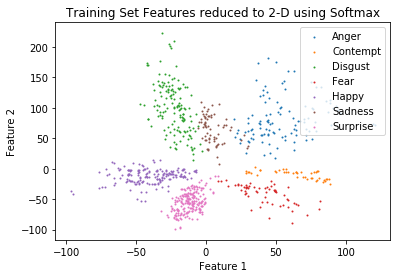

In [92]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
nclass = 7

for i in range(nclass):
    plt.scatter(
        all_features_train[all_labels_train==i, 0],
        all_features_train[all_labels_train==i, 1],
        c=colors[i],
        s=1,
    )
plt.legend(['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise'], loc='upper right')
plt.title('Training Set Features reduced to 2-D using Softmax')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

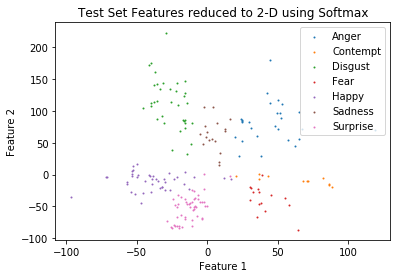

In [93]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
nclass = 7

for i in range(nclass):
    plt.scatter(
        all_features_test[all_labels_test==i, 0],
        all_features_test[all_labels_test==i, 1],
        c=colors[i],
        s=1,
    )
plt.legend(['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise'], loc='upper right')
plt.title('Test Set Features reduced to 2-D using Softmax')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [96]:
model = ConvNet_feature2d().cuda()
criterion_xent = nn.CrossEntropyLoss()
criterion_cent = CenterLoss(num_classes=7, feat_dim=2)
optimizer_model = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_centloss = torch.optim.SGD(criterion_cent.parameters(), lr=0.5)

In [97]:
for epoch in range(100):
    print("==> Epoch {}/{}".format(epoch+1, 100))
    train(model, criterion_xent, criterion_cent,
          optimizer_model, optimizer_centloss,
          trainloader)

    print("==> Test")
    acc, err = test(model, testloader)
    print("Accuracy (%): {}\t Error rate (%): {}".format(acc, err))

==> Epoch 1/100
Batch 1/13	 Loss 2.576382 (2.576382) XentLoss 2.000754 (2.000754) CenterLoss 0.575628 (0.575628)
Batch 2/13	 Loss 2.306837 (2.441609) XentLoss 1.901713 (1.951233) CenterLoss 0.405124 (0.490376)
Batch 3/13	 Loss 2.064131 (2.315783) XentLoss 1.862480 (1.921649) CenterLoss 0.201651 (0.394134)
Batch 4/13	 Loss 2.100083 (2.261858) XentLoss 1.915523 (1.920118) CenterLoss 0.184560 (0.341741)
Batch 5/13	 Loss 2.138876 (2.237262) XentLoss 1.897237 (1.915541) CenterLoss 0.241639 (0.321720)
Batch 6/13	 Loss 2.187791 (2.229017) XentLoss 1.969530 (1.924540) CenterLoss 0.218261 (0.304477)
Batch 7/13	 Loss 1.986660 (2.194394) XentLoss 1.928020 (1.925037) CenterLoss 0.058641 (0.269358)
Batch 8/13	 Loss 2.038281 (2.174880) XentLoss 1.945783 (1.927630) CenterLoss 0.092498 (0.247250)
Batch 9/13	 Loss 2.047026 (2.160674) XentLoss 1.986388 (1.934159) CenterLoss 0.060638 (0.226516)
Batch 10/13	 Loss 1.967735 (2.141380) XentLoss 1.885994 (1.929342) CenterLoss 0.081740 (0.212038)
Batch 11/13	 

Batch 1/13	 Loss 1.838151 (1.838151) XentLoss 1.797495 (1.797495) CenterLoss 0.040656 (0.040656)
Batch 2/13	 Loss 1.895011 (1.866581) XentLoss 1.877206 (1.837351) CenterLoss 0.017804 (0.029230)
Batch 3/13	 Loss 1.817664 (1.850275) XentLoss 1.807765 (1.827489) CenterLoss 0.009898 (0.022786)
Batch 4/13	 Loss 1.761434 (1.828065) XentLoss 1.746932 (1.807350) CenterLoss 0.014503 (0.020715)
Batch 5/13	 Loss 1.848778 (1.832207) XentLoss 1.824898 (1.810859) CenterLoss 0.023880 (0.021348)
Batch 6/13	 Loss 1.781112 (1.823691) XentLoss 1.772642 (1.804490) CenterLoss 0.008469 (0.019202)
Batch 7/13	 Loss 1.886672 (1.832689) XentLoss 1.873811 (1.814393) CenterLoss 0.012861 (0.018296)
Batch 8/13	 Loss 1.889140 (1.839745) XentLoss 1.881089 (1.822730) CenterLoss 0.008050 (0.017015)
Batch 9/13	 Loss 1.823480 (1.837938) XentLoss 1.811260 (1.821455) CenterLoss 0.012221 (0.016483)
Batch 10/13	 Loss 1.940701 (1.848214) XentLoss 1.931020 (1.832412) CenterLoss 0.009681 (0.015802)
Batch 11/13	 Loss 1.777603 (1

Batch 1/13	 Loss 1.786976 (1.786976) XentLoss 1.727569 (1.727569) CenterLoss 0.059407 (0.059407)
Batch 2/13	 Loss 1.722341 (1.754658) XentLoss 1.692761 (1.710165) CenterLoss 0.029580 (0.044493)
Batch 3/13	 Loss 1.704039 (1.737785) XentLoss 1.640539 (1.686956) CenterLoss 0.063500 (0.050829)
Batch 4/13	 Loss 1.939759 (1.788279) XentLoss 1.890440 (1.737827) CenterLoss 0.049319 (0.050451)
Batch 5/13	 Loss 1.796652 (1.789953) XentLoss 1.740026 (1.738267) CenterLoss 0.056626 (0.051686)
Batch 6/13	 Loss 1.847254 (1.799503) XentLoss 1.824803 (1.752689) CenterLoss 0.022451 (0.046814)
Batch 7/13	 Loss 1.712380 (1.787057) XentLoss 1.691991 (1.744018) CenterLoss 0.020390 (0.043039)
Batch 8/13	 Loss 1.617310 (1.765839) XentLoss 1.583057 (1.723898) CenterLoss 0.034252 (0.041941)
Batch 9/13	 Loss 1.826945 (1.772628) XentLoss 1.775456 (1.729627) CenterLoss 0.051489 (0.043001)
Batch 10/13	 Loss 1.745423 (1.769908) XentLoss 1.680070 (1.724671) CenterLoss 0.065353 (0.045237)
Batch 11/13	 Loss 1.695446 (1

Batch 1/13	 Loss 1.649464 (1.649464) XentLoss 1.530150 (1.530150) CenterLoss 0.119314 (0.119314)
Batch 2/13	 Loss 1.554347 (1.601905) XentLoss 1.455317 (1.492734) CenterLoss 0.099029 (0.109172)
Batch 3/13	 Loss 1.715460 (1.639757) XentLoss 1.501863 (1.495777) CenterLoss 0.213597 (0.143980)
Batch 4/13	 Loss 1.524858 (1.611032) XentLoss 1.411814 (1.474786) CenterLoss 0.113043 (0.136246)
Batch 5/13	 Loss 1.638070 (1.616440) XentLoss 1.513520 (1.482533) CenterLoss 0.124551 (0.133907)
Batch 6/13	 Loss 1.527948 (1.601691) XentLoss 1.430038 (1.473784) CenterLoss 0.097910 (0.127907)
Batch 7/13	 Loss 1.596279 (1.600918) XentLoss 1.508901 (1.478801) CenterLoss 0.087378 (0.122117)
Batch 8/13	 Loss 1.494177 (1.587575) XentLoss 1.398595 (1.468775) CenterLoss 0.095582 (0.118800)
Batch 9/13	 Loss 1.599131 (1.588859) XentLoss 1.510983 (1.473465) CenterLoss 0.088148 (0.115395)
Batch 10/13	 Loss 1.681297 (1.598103) XentLoss 1.566406 (1.482759) CenterLoss 0.114891 (0.115344)
Batch 11/13	 Loss 1.491965 (1

Batch 1/13	 Loss 1.336769 (1.336769) XentLoss 1.131333 (1.131333) CenterLoss 0.205436 (0.205436)
Batch 2/13	 Loss 1.358775 (1.347772) XentLoss 1.232998 (1.182166) CenterLoss 0.125777 (0.165607)
Batch 3/13	 Loss 1.440639 (1.378728) XentLoss 1.336043 (1.233458) CenterLoss 0.104596 (0.145270)
Batch 4/13	 Loss 1.284518 (1.355175) XentLoss 0.987871 (1.172061) CenterLoss 0.296647 (0.183114)
Batch 5/13	 Loss 1.324016 (1.348943) XentLoss 1.166388 (1.170926) CenterLoss 0.157628 (0.178017)
Batch 6/13	 Loss 1.481674 (1.371065) XentLoss 1.204352 (1.176497) CenterLoss 0.277322 (0.194568)
Batch 7/13	 Loss 1.259408 (1.355114) XentLoss 1.143971 (1.171851) CenterLoss 0.115437 (0.183263)
Batch 8/13	 Loss 1.617142 (1.387868) XentLoss 1.147686 (1.168830) CenterLoss 0.469457 (0.219037)
Batch 9/13	 Loss 1.313716 (1.379628) XentLoss 1.200005 (1.172294) CenterLoss 0.113711 (0.207335)
Batch 10/13	 Loss 1.370854 (1.378751) XentLoss 1.208043 (1.175869) CenterLoss 0.162812 (0.202882)
Batch 11/13	 Loss 1.411555 (1

Batch 1/13	 Loss 1.263936 (1.263936) XentLoss 1.019137 (1.019137) CenterLoss 0.244799 (0.244799)
Batch 2/13	 Loss 1.027002 (1.145469) XentLoss 0.859105 (0.939121) CenterLoss 0.167897 (0.206348)
Batch 3/13	 Loss 1.278138 (1.189692) XentLoss 1.153938 (1.010727) CenterLoss 0.124201 (0.178966)
Batch 4/13	 Loss 0.840152 (1.102307) XentLoss 0.698829 (0.932752) CenterLoss 0.141323 (0.169555)
Batch 5/13	 Loss 1.109237 (1.103693) XentLoss 0.949330 (0.936068) CenterLoss 0.159907 (0.167625)
Batch 6/13	 Loss 0.903921 (1.070398) XentLoss 0.777614 (0.909659) CenterLoss 0.126307 (0.160739)
Batch 7/13	 Loss 1.129986 (1.078910) XentLoss 0.949849 (0.915400) CenterLoss 0.180136 (0.163510)
Batch 8/13	 Loss 0.966142 (1.064814) XentLoss 0.825504 (0.904163) CenterLoss 0.140637 (0.160651)
Batch 9/13	 Loss 1.134942 (1.072606) XentLoss 0.889794 (0.902567) CenterLoss 0.245148 (0.170039)
Batch 10/13	 Loss 1.096785 (1.075024) XentLoss 0.940255 (0.906336) CenterLoss 0.156529 (0.168688)
Batch 11/13	 Loss 1.167457 (1

Batch 1/13	 Loss 0.701285 (0.701285) XentLoss 0.597634 (0.597634) CenterLoss 0.103650 (0.103650)
Batch 2/13	 Loss 1.117767 (0.909526) XentLoss 0.946089 (0.771861) CenterLoss 0.171679 (0.137665)
Batch 3/13	 Loss 0.761823 (0.860292) XentLoss 0.590630 (0.711451) CenterLoss 0.171192 (0.148841)
Batch 4/13	 Loss 0.748686 (0.832390) XentLoss 0.662524 (0.699219) CenterLoss 0.086163 (0.133171)
Batch 5/13	 Loss 0.895006 (0.844913) XentLoss 0.737907 (0.706957) CenterLoss 0.157099 (0.137957)
Batch 6/13	 Loss 0.805836 (0.838400) XentLoss 0.709768 (0.707425) CenterLoss 0.096068 (0.130975)
Batch 7/13	 Loss 0.848314 (0.839817) XentLoss 0.711317 (0.707981) CenterLoss 0.136997 (0.131835)
Batch 8/13	 Loss 0.839796 (0.839814) XentLoss 0.675447 (0.703914) CenterLoss 0.164349 (0.135900)
Batch 9/13	 Loss 0.866716 (0.842803) XentLoss 0.756799 (0.709790) CenterLoss 0.109917 (0.133013)
Batch 10/13	 Loss 0.731894 (0.831712) XentLoss 0.594548 (0.698266) CenterLoss 0.137345 (0.133446)
Batch 11/13	 Loss 0.812199 (0

Batch 1/13	 Loss 0.921840 (0.921840) XentLoss 0.699000 (0.699000) CenterLoss 0.222840 (0.222840)
Batch 2/13	 Loss 0.747691 (0.834765) XentLoss 0.615056 (0.657028) CenterLoss 0.132635 (0.177738)
Batch 3/13	 Loss 0.648269 (0.772600) XentLoss 0.566237 (0.626764) CenterLoss 0.082032 (0.145836)
Batch 4/13	 Loss 0.807981 (0.781445) XentLoss 0.662269 (0.635640) CenterLoss 0.145712 (0.145805)
Batch 5/13	 Loss 0.545200 (0.734196) XentLoss 0.474108 (0.603334) CenterLoss 0.071092 (0.130862)
Batch 6/13	 Loss 0.618474 (0.714909) XentLoss 0.544347 (0.593503) CenterLoss 0.074127 (0.121406)
Batch 7/13	 Loss 0.644467 (0.704846) XentLoss 0.559841 (0.588694) CenterLoss 0.084627 (0.116152)
Batch 8/13	 Loss 0.625914 (0.694979) XentLoss 0.506213 (0.578384) CenterLoss 0.119701 (0.116596)
Batch 9/13	 Loss 0.579889 (0.682192) XentLoss 0.503027 (0.570011) CenterLoss 0.076862 (0.112181)
Batch 10/13	 Loss 0.674979 (0.681470) XentLoss 0.533706 (0.566380) CenterLoss 0.141273 (0.115090)
Batch 11/13	 Loss 0.619253 (0

Batch 1/13	 Loss 0.567580 (0.567580) XentLoss 0.503973 (0.503973) CenterLoss 0.063607 (0.063607)
Batch 2/13	 Loss 0.554067 (0.560823) XentLoss 0.504137 (0.504055) CenterLoss 0.049929 (0.056768)
Batch 3/13	 Loss 0.528802 (0.550149) XentLoss 0.432535 (0.480215) CenterLoss 0.096267 (0.069934)
Batch 4/13	 Loss 0.515684 (0.541533) XentLoss 0.455002 (0.473912) CenterLoss 0.060682 (0.067621)
Batch 5/13	 Loss 0.534846 (0.540196) XentLoss 0.475640 (0.474258) CenterLoss 0.059206 (0.065938)
Batch 6/13	 Loss 0.535687 (0.539444) XentLoss 0.458487 (0.471629) CenterLoss 0.077200 (0.067815)
Batch 7/13	 Loss 0.532232 (0.538414) XentLoss 0.449444 (0.468460) CenterLoss 0.082788 (0.069954)
Batch 8/13	 Loss 0.558138 (0.540879) XentLoss 0.487992 (0.470901) CenterLoss 0.070146 (0.069978)
Batch 9/13	 Loss 0.554391 (0.542381) XentLoss 0.451252 (0.468718) CenterLoss 0.103139 (0.073663)
Batch 10/13	 Loss 0.434028 (0.531546) XentLoss 0.383106 (0.460157) CenterLoss 0.050922 (0.071389)
Batch 11/13	 Loss 0.488373 (0

Batch 1/13	 Loss 0.488426 (0.488426) XentLoss 0.426157 (0.426157) CenterLoss 0.062268 (0.062268)
Batch 2/13	 Loss 0.503698 (0.496062) XentLoss 0.436092 (0.431125) CenterLoss 0.067605 (0.064937)
Batch 3/13	 Loss 0.296457 (0.429527) XentLoss 0.222537 (0.361596) CenterLoss 0.073919 (0.067931)
Batch 4/13	 Loss 0.313582 (0.400541) XentLoss 0.226507 (0.327823) CenterLoss 0.087076 (0.072717)
Batch 5/13	 Loss 0.468126 (0.414058) XentLoss 0.364073 (0.335073) CenterLoss 0.104053 (0.078984)
Batch 6/13	 Loss 0.382619 (0.408818) XentLoss 0.334798 (0.335027) CenterLoss 0.047822 (0.073791)
Batch 7/13	 Loss 0.700928 (0.450548) XentLoss 0.585194 (0.370765) CenterLoss 0.115734 (0.079783)
Batch 8/13	 Loss 0.567399 (0.465154) XentLoss 0.473866 (0.383653) CenterLoss 0.093534 (0.081501)
Batch 9/13	 Loss 0.554199 (0.475048) XentLoss 0.490946 (0.395574) CenterLoss 0.063253 (0.079474)
Batch 10/13	 Loss 0.426427 (0.470186) XentLoss 0.348668 (0.390884) CenterLoss 0.077759 (0.079302)
Batch 11/13	 Loss 0.329381 (0

Batch 1/13	 Loss 0.402008 (0.402008) XentLoss 0.351168 (0.351168) CenterLoss 0.050841 (0.050841)
Batch 2/13	 Loss 0.351794 (0.376901) XentLoss 0.260372 (0.305770) CenterLoss 0.091422 (0.071131)
Batch 3/13	 Loss 0.396753 (0.383519) XentLoss 0.331897 (0.314479) CenterLoss 0.064856 (0.069039)
Batch 4/13	 Loss 0.557620 (0.427044) XentLoss 0.492723 (0.359040) CenterLoss 0.064897 (0.068004)
Batch 5/13	 Loss 0.435231 (0.428681) XentLoss 0.362193 (0.359671) CenterLoss 0.073038 (0.069011)
Batch 6/13	 Loss 0.509869 (0.442213) XentLoss 0.437772 (0.372688) CenterLoss 0.072097 (0.069525)
Batch 7/13	 Loss 0.413729 (0.438144) XentLoss 0.335551 (0.367382) CenterLoss 0.078179 (0.070761)
Batch 8/13	 Loss 0.369656 (0.429583) XentLoss 0.288271 (0.357493) CenterLoss 0.081385 (0.072089)
Batch 9/13	 Loss 0.340351 (0.419668) XentLoss 0.289798 (0.349972) CenterLoss 0.050553 (0.069696)
Batch 10/13	 Loss 0.360884 (0.413790) XentLoss 0.292752 (0.344250) CenterLoss 0.068131 (0.069540)
Batch 11/13	 Loss 0.366276 (0

Batch 1/13	 Loss 0.538091 (0.538091) XentLoss 0.466049 (0.466049) CenterLoss 0.072042 (0.072042)
Batch 2/13	 Loss 0.353755 (0.445923) XentLoss 0.300448 (0.383249) CenterLoss 0.053306 (0.062674)
Batch 3/13	 Loss 0.330150 (0.407332) XentLoss 0.242598 (0.336365) CenterLoss 0.087552 (0.070967)
Batch 4/13	 Loss 0.370851 (0.398212) XentLoss 0.293541 (0.325659) CenterLoss 0.077310 (0.072553)
Batch 5/13	 Loss 0.256965 (0.369962) XentLoss 0.203039 (0.301135) CenterLoss 0.053926 (0.068827)
Batch 6/13	 Loss 0.312445 (0.360376) XentLoss 0.211193 (0.286145) CenterLoss 0.101252 (0.074231)
Batch 7/13	 Loss 0.381828 (0.363441) XentLoss 0.327259 (0.292018) CenterLoss 0.054569 (0.071423)
Batch 8/13	 Loss 0.357930 (0.362752) XentLoss 0.259962 (0.288011) CenterLoss 0.097968 (0.074741)
Batch 9/13	 Loss 0.475927 (0.375327) XentLoss 0.426759 (0.303428) CenterLoss 0.049168 (0.071899)
Batch 10/13	 Loss 0.311916 (0.368986) XentLoss 0.260173 (0.299102) CenterLoss 0.051743 (0.069884)
Batch 11/13	 Loss 0.397520 (0

Batch 1/13	 Loss 0.356313 (0.356313) XentLoss 0.284595 (0.284595) CenterLoss 0.071718 (0.071718)
Batch 2/13	 Loss 0.332571 (0.344442) XentLoss 0.255811 (0.270203) CenterLoss 0.076759 (0.074239)
Batch 3/13	 Loss 0.425930 (0.371605) XentLoss 0.354404 (0.298270) CenterLoss 0.071527 (0.073335)
Batch 4/13	 Loss 0.392579 (0.376848) XentLoss 0.315185 (0.302499) CenterLoss 0.077395 (0.074350)
Batch 5/13	 Loss 0.341850 (0.369849) XentLoss 0.239942 (0.289987) CenterLoss 0.101909 (0.079861)
Batch 6/13	 Loss 0.319328 (0.361429) XentLoss 0.276803 (0.287790) CenterLoss 0.042525 (0.073639)
Batch 7/13	 Loss 0.343885 (0.358922) XentLoss 0.271073 (0.285402) CenterLoss 0.072812 (0.073521)
Batch 8/13	 Loss 0.422436 (0.366862) XentLoss 0.349233 (0.293381) CenterLoss 0.073203 (0.073481)
Batch 9/13	 Loss 0.360103 (0.366111) XentLoss 0.264280 (0.290147) CenterLoss 0.095823 (0.075963)
Batch 10/13	 Loss 0.343508 (0.363850) XentLoss 0.285188 (0.289651) CenterLoss 0.058320 (0.074199)
Batch 11/13	 Loss 0.279796 (0

Batch 1/13	 Loss 0.250546 (0.250546) XentLoss 0.214117 (0.214117) CenterLoss 0.036429 (0.036429)
Batch 2/13	 Loss 0.242907 (0.246726) XentLoss 0.217453 (0.215785) CenterLoss 0.025454 (0.030941)
Batch 3/13	 Loss 0.248568 (0.247340) XentLoss 0.219260 (0.216943) CenterLoss 0.029308 (0.030397)
Batch 4/13	 Loss 0.321937 (0.265989) XentLoss 0.283445 (0.233569) CenterLoss 0.038492 (0.032421)
Batch 5/13	 Loss 0.309216 (0.274635) XentLoss 0.263671 (0.239589) CenterLoss 0.045544 (0.035045)
Batch 6/13	 Loss 0.337621 (0.285132) XentLoss 0.283429 (0.246896) CenterLoss 0.054193 (0.038237)
Batch 7/13	 Loss 0.258131 (0.281275) XentLoss 0.222374 (0.243393) CenterLoss 0.035756 (0.037882)
Batch 8/13	 Loss 0.280356 (0.281160) XentLoss 0.239360 (0.242889) CenterLoss 0.040996 (0.038272)
Batch 9/13	 Loss 0.262015 (0.279033) XentLoss 0.227239 (0.241150) CenterLoss 0.034776 (0.037883)
Batch 10/13	 Loss 0.311817 (0.282311) XentLoss 0.273247 (0.244360) CenterLoss 0.038570 (0.037952)
Batch 11/13	 Loss 0.368690 (0

Batch 1/13	 Loss 0.324827 (0.324827) XentLoss 0.270058 (0.270058) CenterLoss 0.054770 (0.054770)
Batch 2/13	 Loss 0.229330 (0.277079) XentLoss 0.174311 (0.222184) CenterLoss 0.055019 (0.054895)
Batch 3/13	 Loss 0.317736 (0.290631) XentLoss 0.258258 (0.234209) CenterLoss 0.059478 (0.056422)
Batch 4/13	 Loss 0.325654 (0.299387) XentLoss 0.275783 (0.244602) CenterLoss 0.049871 (0.054785)
Batch 5/13	 Loss 0.222579 (0.284025) XentLoss 0.163504 (0.228383) CenterLoss 0.059075 (0.055643)
Batch 6/13	 Loss 0.370526 (0.298442) XentLoss 0.289940 (0.238642) CenterLoss 0.080586 (0.059800)
Batch 7/13	 Loss 0.286626 (0.296754) XentLoss 0.239037 (0.238699) CenterLoss 0.047589 (0.058055)
Batch 8/13	 Loss 0.274537 (0.293977) XentLoss 0.170971 (0.230233) CenterLoss 0.103566 (0.063744)
Batch 9/13	 Loss 0.193599 (0.282824) XentLoss 0.141432 (0.220366) CenterLoss 0.052167 (0.062458)
Batch 10/13	 Loss 0.279151 (0.282457) XentLoss 0.213227 (0.219652) CenterLoss 0.065924 (0.062804)
Batch 11/13	 Loss 0.325921 (0

Batch 1/13	 Loss 0.194775 (0.194775) XentLoss 0.152721 (0.152721) CenterLoss 0.042054 (0.042054)
Batch 2/13	 Loss 0.265566 (0.230171) XentLoss 0.209099 (0.180910) CenterLoss 0.056467 (0.049261)
Batch 3/13	 Loss 0.318087 (0.259476) XentLoss 0.285366 (0.215729) CenterLoss 0.032720 (0.043747)
Batch 4/13	 Loss 0.291875 (0.267576) XentLoss 0.237860 (0.221262) CenterLoss 0.054015 (0.046314)
Batch 5/13	 Loss 0.250811 (0.264223) XentLoss 0.209841 (0.218978) CenterLoss 0.040970 (0.045245)
Batch 6/13	 Loss 0.269466 (0.265097) XentLoss 0.228399 (0.220548) CenterLoss 0.041067 (0.044549)
Batch 7/13	 Loss 0.215787 (0.258052) XentLoss 0.163647 (0.212419) CenterLoss 0.052141 (0.045633)
Batch 8/13	 Loss 0.213984 (0.252544) XentLoss 0.183422 (0.208794) CenterLoss 0.030562 (0.043749)
Batch 9/13	 Loss 0.180309 (0.244518) XentLoss 0.150669 (0.202336) CenterLoss 0.029640 (0.042182)
Batch 10/13	 Loss 0.302191 (0.250285) XentLoss 0.264638 (0.208566) CenterLoss 0.037553 (0.041719)
Batch 11/13	 Loss 0.261196 (0

Batch 1/13	 Loss 0.215497 (0.215497) XentLoss 0.139768 (0.139768) CenterLoss 0.075729 (0.075729)
Batch 2/13	 Loss 0.174842 (0.195170) XentLoss 0.125289 (0.132528) CenterLoss 0.049553 (0.062641)
Batch 3/13	 Loss 0.233216 (0.207852) XentLoss 0.118707 (0.127921) CenterLoss 0.114508 (0.079930)
Batch 4/13	 Loss 0.252067 (0.218906) XentLoss 0.215048 (0.149703) CenterLoss 0.037019 (0.069203)
Batch 5/13	 Loss 0.301558 (0.235436) XentLoss 0.222288 (0.164220) CenterLoss 0.079270 (0.071216)
Batch 6/13	 Loss 0.289981 (0.244527) XentLoss 0.232654 (0.175626) CenterLoss 0.057327 (0.068901)
Batch 7/13	 Loss 0.246501 (0.244809) XentLoss 0.205900 (0.179951) CenterLoss 0.040601 (0.064858)
Batch 8/13	 Loss 0.233012 (0.243334) XentLoss 0.173177 (0.179104) CenterLoss 0.059835 (0.064230)
Batch 9/13	 Loss 0.287298 (0.248219) XentLoss 0.216767 (0.183289) CenterLoss 0.070531 (0.064931)
Batch 10/13	 Loss 0.278380 (0.251235) XentLoss 0.211889 (0.186149) CenterLoss 0.066491 (0.065087)
Batch 11/13	 Loss 0.253880 (0

In [98]:
ypred_train, ytrue_train, feat_train = Get_Features(model, trainloader)
ypred_test, ytrue_test, feat_test = Get_Features(model, testloader)

In [99]:
#Concatenate training features
all_features_train = np.concatenate(feat_train, 0)
all_pred_train = np.concatenate(ypred_train, 0)
all_labels_train = np.concatenate(ytrue_train, 0)
#Concatenate test features
all_features_test = np.concatenate(feat_test, 0)
all_pred_test = np.concatenate(ypred_test, 0)
all_labels_test = np.concatenate(ytrue_test, 0)

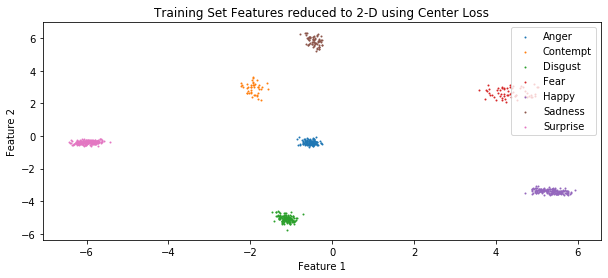

In [109]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
nclass = 7

plt.figure(figsize=(10,4))
for i in range(nclass):
    plt.scatter(
        all_features_train[all_labels_train==i, 0],
        all_features_train[all_labels_train==i, 1],
        c=colors[i],
        s=1,
    )
plt.legend(['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise'], loc='upper right')
plt.title('Training Set Features reduced to 2-D using Center Loss')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

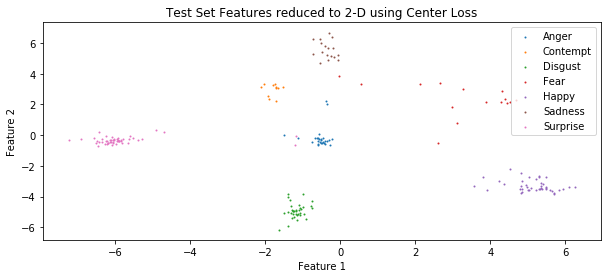

In [108]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
nclass = 7

plt.figure(figsize=(10,4))
for i in range(nclass):
    plt.scatter(
        all_features_test[all_labels_test==i, 0],
        all_features_test[all_labels_test==i, 1],
        c=colors[i],
        s=1,
    )
plt.legend(['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise'], loc='upper right')
plt.title('Test Set Features reduced to 2-D using Center Loss')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [116]:
torch.save(model.state_dict(),'model/model1.pth')